# Q1

## Part1: Preprocessing

### Import data

In [1]:
import torch
import os
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns
from timeit import default_timer as timer

### Define transforms

In [2]:
mean, std = 0.5, 0.5

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

### Download datasets and save into `train_dataset` and `test_dataset`

In [3]:
train_dataset_FashionMNIST = torchvision.datasets.FashionMNIST(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = transform # images come as PIL format, we want to turn into Torch tensors
)

test_dataset_FashionMNIST = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False, # get test data
    download = True,
    transform = transform
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13206703.39it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206621.65it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3940033.37it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23418955.52it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
train_dataset_MNIST = torchvision.datasets.MNIST(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = transform # images come as PIL format, we want to turn into Torch tensors
)

test_dataset_MNIST = torchvision.datasets.MNIST(
    root = "data",
    train = False, # get test data
    download = True,
    transform = transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 129192143.40it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22267590.78it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18985879.50it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16171925.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = transform # images come as PIL format, we want to turn into Torch tensors
)

test_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root = "data",
    train = False, # get test data
    download = True,
    transform = transform
)

100%|██████████| 170498071/170498071 [00:04<00:00, 34498284.79it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Create dataloaders

In [6]:
def create_dataloader(train_dataset, test_dataset, batch_size):
  train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = batch_size,
      num_workers = 2,
      shuffle = True
  )

  test_dataloader = DataLoader(
      dataset = test_dataset,
      batch_size = batch_size,
      num_workers = 2,
      shuffle = False
  )
  return train_dataloader, test_dataloader

In [7]:
train_dataloader_FashionMNIST, test_dataloader_FashionMNIST = create_dataloader(
    train_dataset_FashionMNIST, test_dataset_FashionMNIST, 128)

train_dataloader_MNIST, test_dataloader_MNIST = create_dataloader(
    train_dataset_MNIST, test_dataset_MNIST, 128)

train_dataloader_CIFAR10, test_dataloader_CIFAR10 = create_dataloader(
    train_dataset_CIFAR10, test_dataset_CIFAR10, 128)


### Show one sample from each dataset

In [8]:
def show_sample(train_dataloader, mean, std):
  # Check out what's inside the training dataloader
  train_features_batch, train_labels_batch = next(iter(train_dataloader))
  print("train_features_batch.shape = " + str(train_features_batch.shape) +
        ", train_labels_batch.shape = " + str(train_labels_batch.shape))
  img, label = train_features_batch[0], train_labels_batch[0]
  img = std * img + mean
  plt.imshow(img.permute(1, 2, 0), cmap='gray')
  plt.axis("Off");
  print(f"Image size: {img.shape}")
  print(f"Label: {label}")

train_features_batch.shape = torch.Size([128, 1, 28, 28]), train_labels_batch.shape = torch.Size([128])
Image size: torch.Size([1, 28, 28])
Label: 2


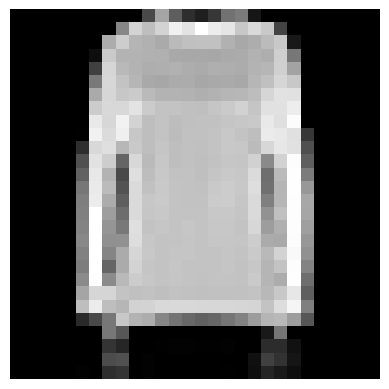

In [9]:
# FashionMNIST sample
show_sample(train_dataloader_FashionMNIST, mean, std)

train_features_batch.shape = torch.Size([128, 1, 28, 28]), train_labels_batch.shape = torch.Size([128])
Image size: torch.Size([1, 28, 28])
Label: 7


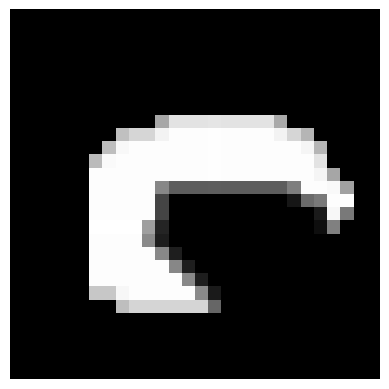

In [10]:
# MNIST sample
show_sample(train_dataloader_MNIST, mean, std)

train_features_batch.shape = torch.Size([128, 3, 32, 32]), train_labels_batch.shape = torch.Size([128])
Image size: torch.Size([3, 32, 32])
Label: 3


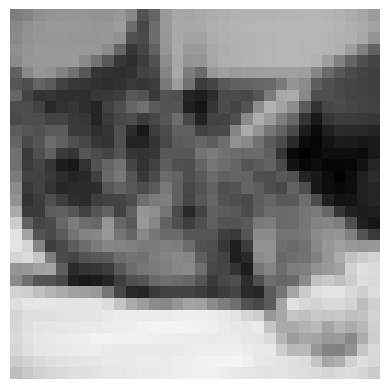

In [11]:
# CIFAR10 sample
show_sample(train_dataloader_CIFAR10, mean, std)

## Part2: Implementing Structures

### Define number of classes from each dataset

In [9]:
num_classes_MNIST = len(train_dataset_MNIST.classes)
num_classes_FashionMNIST = len(train_dataset_FashionMNIST.classes)
num_classes_CIFAR10 = len(train_dataset_CIFAR10.classes)

### Create SCNNB model

In [10]:
# Create a shallow convolutional neural network
class SCNNB(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()

        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*hidden_shape*hidden_shape, out_features = 1280),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 1280, out_features = output_shape)

        )

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        x = self.CNN_block(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        x = F.softmax(x, dim=1)  # Apply softmax here
        return x


In [11]:
model1 = SCNNB(input_shape=1, hidden_shape=5, output_shape=num_classes_MNIST)
model2 = SCNNB(input_shape=1, hidden_shape=5, output_shape=num_classes_FashionMNIST)
model3 = SCNNB(input_shape=3, hidden_shape=6, output_shape=num_classes_CIFAR10)

Check input of SCNNB model

In [12]:
random_sample = torch.randn((1, 3, 32, 32))
model3(random_sample).shape

torch.Size([1, 10])

### Create SCNNB-a model

In [13]:
# Create a shallow convolutional neural network
class SCNNB_a(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()

        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size = 3),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*hidden_shape*hidden_shape, out_features = 1280),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 1280, out_features = output_shape)

        )

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        x = self.CNN_block(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        x = F.softmax(x, dim=1)  # Apply softmax here
        return x


In [14]:
model4 = SCNNB_a(input_shape=1, hidden_shape=5, output_shape=num_classes_MNIST)
model5 = SCNNB_a(input_shape=1, hidden_shape=5, output_shape=num_classes_FashionMNIST)
model6 = SCNNB_a(input_shape=3, hidden_shape=6, output_shape=num_classes_CIFAR10)

### Create SCNNB-b model

In [15]:
# Create a shallow convolutional neural network
class SCNNB_b(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()

        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size = 3),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size = 3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*hidden_shape*hidden_shape, out_features = 1280),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 1280, out_features = output_shape)

        )

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        x = self.CNN_block(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        x = F.softmax(x, dim=1)  # Apply softmax here
        return x


In [16]:
model7 = SCNNB_b(input_shape=1, hidden_shape=5, output_shape=num_classes_MNIST)
model8 = SCNNB_b(input_shape=1, hidden_shape=5, output_shape=num_classes_FashionMNIST)
model9 = SCNNB_b(input_shape=3, hidden_shape=6, output_shape=num_classes_CIFAR10)

### Define `train_step` & `test_step`

In [17]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):

    # Send model to GPU
    model.to(device)

    # put model in train mode
    model.train()
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss.item(), train_acc

In [18]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):

    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss.item()/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

### Define `accuracy_fn`, `loss_fn` and `optimizer`

In [19]:
def accuracy_fn(true, pred):
    pred = torch.argmax(pred, dim=1)
    acc = (true == pred).float().mean().item()
    return acc

In [20]:
def optimizer(model):
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.000005)
  return optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer1 = optimizer(model1)
optimizer2 = optimizer(model2)
optimizer3 = optimizer(model3)
optimizer4 = optimizer(model4)
optimizer5 = optimizer(model5)
optimizer6 = optimizer(model6)
optimizer7 = optimizer(model7)
optimizer8 = optimizer(model8)
optimizer9 = optimizer(model9)

### Define `fit` function

In [22]:
def fit(model, train_dataloader, test_dataloader, optimizer, epochs):
  train_epoch_loss = []
  train_epoch_accuracy = []
  test_epoch_loss = []
  test_epoch_accuracy = []

  train_time_start = timer()

  for epoch in range(epochs):
      print("EPOCH {}/{} :".format(epoch +1, epochs))
      train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                model=model,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                accuracy_fn=accuracy_fn,
                                                device=device
                                                )
      test_loss, test_acc = test_step(data_loader=test_dataloader,
                                      model=model,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device
                                      )

      train_epoch_loss.append(train_loss)
      train_epoch_accuracy.append(train_acc)
      test_epoch_loss.append(test_loss)
      test_epoch_accuracy.append(test_acc)

  train_time_end = timer()
  total_time = train_time_end - train_time_start
  print(f"\n\nTrain time: {total_time:.5f} seconds")
  return train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy

## Part3: Implementation Results

### Define plot function

In [23]:
def accloss_plots(train_loss1, test_loss1, train_acc1, test_acc1,
                  train_loss2, test_loss2, train_acc2, test_acc2,
                  train_loss3, test_loss3, train_acc3, test_acc3):
    num_epochs = len(train_loss1)
    plt.figure(figsize=(13, 10))

    # Plot training loss for all sets
    plt.subplot(221)
    plt.plot(train_loss1, '-.', label='Train Set SCNNB')
    plt.plot(train_loss2, '-.', label='Train Set SCNNB-a')
    plt.plot(train_loss3, '-.', label='Train Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot training accuracy for all sets
    plt.subplot(222)
    plt.plot(train_acc1, '-.', label='Train Set SCNNB')
    plt.plot(train_acc2, '-.', label='Train Set SCNNB-a')
    plt.plot(train_acc3, '-.', label='Train Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot testing loss for all sets
    plt.subplot(223)
    plt.plot(test_loss1, '-.', label='Test Set SCNNB')
    plt.plot(test_loss2, '-.', label='Test Set SCNNB-a')
    plt.plot(test_loss3, '-.', label='Test Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot testing accuracy for all sets
    plt.subplot(224)
    plt.plot(test_acc1, '-.', label='Test Set SCNNB')
    plt.plot(test_acc2, '-.', label='Test Set SCNNB-a')
    plt.plot(test_acc3, '-.', label='Test Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()

    plt.show()


### Fit for MNIST dataset

In [ ]:
train_loss1, test_loss1, train_acc1, test_acc1 = fit(
    model1, train_dataloader_MNIST, test_dataloader_MNIST, optimizer1, 40)

EPOCH 1/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 16.05it/s, test_acc=0.876, test_loss=1.59]


EPOCH 2/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.62it/s, test_acc=0.946, test_loss=1.52]


EPOCH 3/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.46it/s, test_acc=0.974, test_loss=1.49]


EPOCH 4/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.72it/s, test_acc=0.976, test_loss=1.49]


EPOCH 5/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.11it/s, test_acc=0.98, test_loss=1.48]


EPOCH 6/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.99it/s, test_acc=0.982, test_loss=1.48]


EPOCH 7/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 26.56it/s, test_acc=0.977, test_loss=1.48]


EPOCH 8/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s, test_acc=0.984, test_loss=1.48]


EPOCH 9/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.27it/s, test_acc=0.985, test_loss=1.48]


EPOCH 10/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.85it/s, test_acc=0.984, test_loss=1.48]


EPOCH 11/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.29it/s, test_acc=0.984, test_loss=1.48]


EPOCH 12/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.58it/s, test_acc=0.987, test_loss=1.47]


EPOCH 13/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.87it/s, test_acc=0.987, test_loss=1.47]


EPOCH 14/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.48it/s, test_acc=0.985, test_loss=1.48]


EPOCH 15/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.53it/s, test_acc=0.988, test_loss=1.47]


EPOCH 16/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.59it/s, test_acc=0.985, test_loss=1.48]


EPOCH 17/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.17it/s, test_acc=0.988, test_loss=1.47]


EPOCH 18/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s, test_acc=0.986, test_loss=1.47]


EPOCH 19/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.58it/s, test_acc=0.987, test_loss=1.47]


EPOCH 20/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.13it/s, test_acc=0.988, test_loss=1.47]


EPOCH 21/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.59it/s, test_acc=0.989, test_loss=1.47]


EPOCH 22/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s, test_acc=0.988, test_loss=1.47]


EPOCH 23/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.17it/s, test_acc=0.987, test_loss=1.47]


EPOCH 24/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s, test_acc=0.989, test_loss=1.47]


EPOCH 25/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 17.54it/s, test_acc=0.989, test_loss=1.47]


EPOCH 26/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 26.13it/s, test_acc=0.987, test_loss=1.47]


EPOCH 27/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.09it/s, test_acc=0.988, test_loss=1.47]


EPOCH 28/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.65it/s, test_acc=0.988, test_loss=1.47]


EPOCH 29/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.67it/s, test_acc=0.987, test_loss=1.47]


EPOCH 30/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.56it/s, test_acc=0.988, test_loss=1.47]


EPOCH 31/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.21it/s, test_acc=0.988, test_loss=1.47]


EPOCH 32/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s, test_acc=0.99, test_loss=1.47]


EPOCH 33/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.45it/s, test_acc=0.989, test_loss=1.47]


EPOCH 34/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.57it/s, test_acc=0.99, test_loss=1.47]


EPOCH 35/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.35it/s, test_acc=0.99, test_loss=1.47]


EPOCH 36/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.42it/s, test_acc=0.989, test_loss=1.47]


EPOCH 37/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s, test_acc=0.989, test_loss=1.47]


EPOCH 38/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.40it/s, test_acc=0.989, test_loss=1.47]


EPOCH 39/40 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s, test_acc=0.99, test_loss=1.47]


EPOCH 40/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.83it/s, test_acc=0.99, test_loss=1.47]




Train time: 871.01955 seconds


In [ ]:
train_loss4, test_loss4, train_acc4, test_acc4 = fit(
    model4, train_dataloader_MNIST, test_dataloader_MNIST, optimizer4, 40)

In [ ]:
train_loss7, test_loss7, train_acc7, test_acc7 = fit(
    model7, train_dataloader_MNIST, test_dataloader_MNIST, optimizer7, 40)

### Results for MNIST dataset

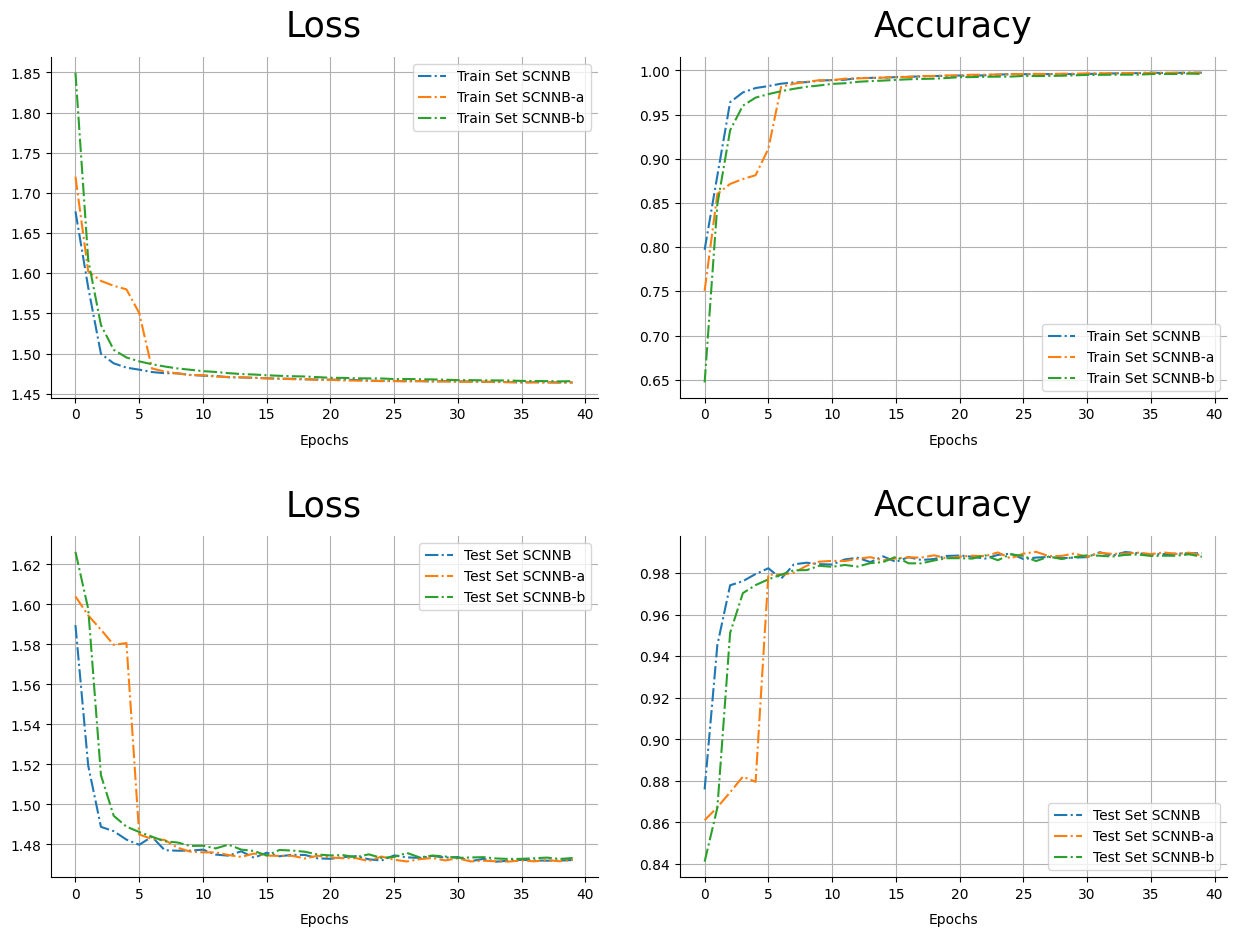

In [ ]:
accloss_plots(train_loss1, test_loss1, train_acc1, test_acc1,
                  train_loss4, test_loss4, train_acc4, test_acc4,
                  train_loss7, test_loss7, train_acc7, test_acc7)

### Fit for FashionMNIST dataset

In [27]:
train_loss2, test_loss2, train_acc2, test_acc2 = fit(
    model2, train_dataloader_FashionMNIST, test_dataloader_FashionMNIST, optimizer2, 30)

EPOCH 1/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.30it/s, test_acc=0.831, test_loss=1.63]


EPOCH 2/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.89it/s, test_acc=0.856, test_loss=1.61]


EPOCH 3/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.63it/s, test_acc=0.865, test_loss=1.6]


EPOCH 4/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.85it/s, test_acc=0.873, test_loss=1.59]


EPOCH 5/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.89it/s, test_acc=0.873, test_loss=1.59]


EPOCH 6/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.88it/s, test_acc=0.876, test_loss=1.59]


EPOCH 7/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.95it/s, test_acc=0.871, test_loss=1.59]


EPOCH 8/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.60it/s, test_acc=0.881, test_loss=1.58]


EPOCH 9/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.49it/s, test_acc=0.878, test_loss=1.58]


EPOCH 10/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.34it/s, test_acc=0.887, test_loss=1.58]


EPOCH 11/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.77it/s, test_acc=0.89, test_loss=1.57]


EPOCH 12/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.57it/s, test_acc=0.892, test_loss=1.57]


EPOCH 13/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s, test_acc=0.892, test_loss=1.57]


EPOCH 14/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.62it/s, test_acc=0.891, test_loss=1.57]


EPOCH 15/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.72it/s, test_acc=0.895, test_loss=1.57]


EPOCH 16/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.65it/s, test_acc=0.902, test_loss=1.56]


EPOCH 17/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.93it/s, test_acc=0.896, test_loss=1.57]


EPOCH 18/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.92it/s, test_acc=0.899, test_loss=1.56]


EPOCH 19/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.70it/s, test_acc=0.9, test_loss=1.56]


EPOCH 20/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.48it/s, test_acc=0.899, test_loss=1.56]


EPOCH 21/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.01it/s, test_acc=0.9, test_loss=1.56]


EPOCH 22/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.37it/s, test_acc=0.902, test_loss=1.56]


EPOCH 23/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s, test_acc=0.901, test_loss=1.56]


EPOCH 24/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s, test_acc=0.9, test_loss=1.56]


EPOCH 25/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.18it/s, test_acc=0.899, test_loss=1.56]


EPOCH 26/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.88it/s, test_acc=0.907, test_loss=1.55]


EPOCH 27/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.54it/s, test_acc=0.909, test_loss=1.55]


EPOCH 28/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.37it/s, test_acc=0.906, test_loss=1.56]


EPOCH 29/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s, test_acc=0.904, test_loss=1.56]


EPOCH 30/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.23it/s, test_acc=0.911, test_loss=1.55]



Train time: 607.90227 seconds


In [ ]:
train_loss5, test_loss5, train_acc5, test_acc5 = fit(
    model5, train_dataloader_FashionMNIST, test_dataloader_FashionMNIST, optimizer5, 30)

In [30]:
train_loss8, test_loss8, train_acc8, test_acc8 = fit(
    model8, train_dataloader_FashionMNIST, test_dataloader_FashionMNIST, optimizer8, 30)

EPOCH 1/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.51it/s, test_acc=0.749, test_loss=1.72]


EPOCH 2/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.59it/s, test_acc=0.782, test_loss=1.68]


EPOCH 3/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s, test_acc=0.799, test_loss=1.66]


EPOCH 4/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.96it/s, test_acc=0.807, test_loss=1.66]


EPOCH 5/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.64it/s, test_acc=0.813, test_loss=1.65]


EPOCH 6/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.41it/s, test_acc=0.819, test_loss=1.64]


EPOCH 7/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.79it/s, test_acc=0.822, test_loss=1.64]


EPOCH 8/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.38it/s, test_acc=0.824, test_loss=1.64]


EPOCH 9/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.26it/s, test_acc=0.827, test_loss=1.64]


EPOCH 10/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.50it/s, test_acc=0.832, test_loss=1.63]


EPOCH 11/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.98it/s, test_acc=0.832, test_loss=1.63]


EPOCH 12/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.29it/s, test_acc=0.83, test_loss=1.63]


EPOCH 13/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.23it/s, test_acc=0.835, test_loss=1.63]


EPOCH 14/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.97it/s, test_acc=0.835, test_loss=1.63]


EPOCH 15/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.40it/s, test_acc=0.836, test_loss=1.63]


EPOCH 16/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.97it/s, test_acc=0.837, test_loss=1.63]


EPOCH 17/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.39it/s, test_acc=0.838, test_loss=1.62]


EPOCH 18/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.30it/s, test_acc=0.84, test_loss=1.62]


EPOCH 19/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.03it/s, test_acc=0.84, test_loss=1.62]


EPOCH 20/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.10it/s, test_acc=0.84, test_loss=1.62]


EPOCH 21/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.40it/s, test_acc=0.843, test_loss=1.62]


EPOCH 22/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.65it/s, test_acc=0.843, test_loss=1.62]


EPOCH 23/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.07it/s, test_acc=0.845, test_loss=1.62]


EPOCH 24/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.75it/s, test_acc=0.855, test_loss=1.61]


EPOCH 25/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.02it/s, test_acc=0.871, test_loss=1.59]


EPOCH 26/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.90it/s, test_acc=0.884, test_loss=1.58]


EPOCH 27/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.09it/s, test_acc=0.884, test_loss=1.58]


EPOCH 28/30 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.56it/s, test_acc=0.882, test_loss=1.58]


EPOCH 29/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.45it/s, test_acc=0.881, test_loss=1.58]


EPOCH 30/30 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.71it/s, test_acc=0.889, test_loss=1.57]



Train time: 612.02169 seconds


### Results for FashionMNIST dataset

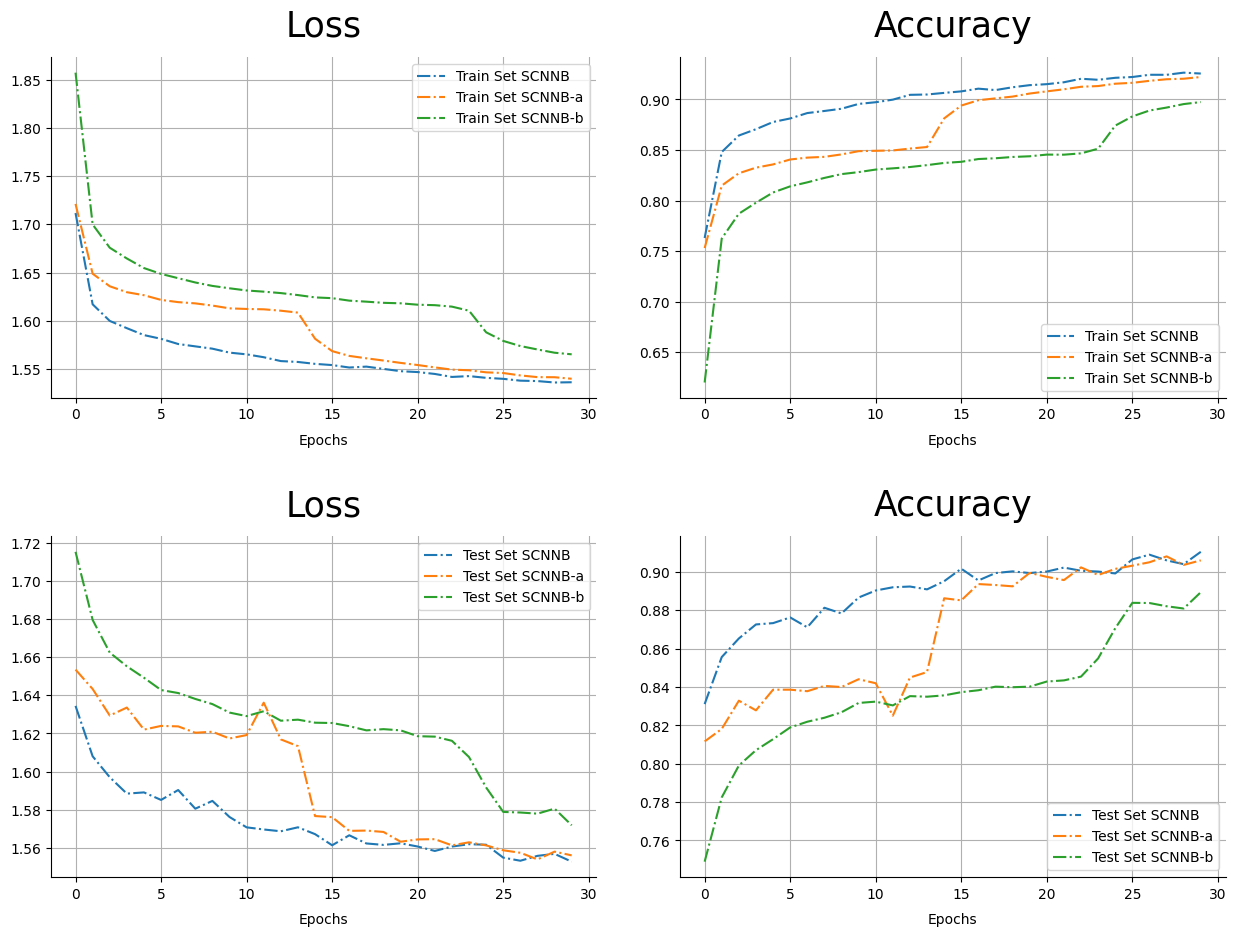

In [31]:
accloss_plots(train_loss2, test_loss2, train_acc2, test_acc2,
                  train_loss5, test_loss5, train_acc5, test_acc5,
                  train_loss8, test_loss8, train_acc8, test_acc8)

### Fit for CIFAR10 dataset

In [24]:
train_loss3, test_loss3, train_acc3, test_acc3 = fit(
    model3, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer3, 40)

EPOCH 1/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.34it/s, test_acc=0.506, test_loss=1.95]


EPOCH 2/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.33it/s, test_acc=0.579, test_loss=1.88]


EPOCH 3/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.74it/s, test_acc=0.615, test_loss=1.85]


EPOCH 4/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.64it/s, test_acc=0.634, test_loss=1.83]


EPOCH 5/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.06it/s, test_acc=0.644, test_loss=1.82]


EPOCH 6/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.44it/s, test_acc=0.664, test_loss=1.8]


EPOCH 7/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.19it/s, test_acc=0.678, test_loss=1.78]


EPOCH 8/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.49it/s, test_acc=0.677, test_loss=1.78]


EPOCH 9/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.13it/s, test_acc=0.697, test_loss=1.76]


EPOCH 10/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.19it/s, test_acc=0.7, test_loss=1.76]


EPOCH 11/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.10it/s, test_acc=0.716, test_loss=1.75]


EPOCH 12/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.85it/s, test_acc=0.702, test_loss=1.76]


EPOCH 13/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.91it/s, test_acc=0.735, test_loss=1.73]


EPOCH 14/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.90it/s, test_acc=0.705, test_loss=1.76]


EPOCH 15/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.86it/s, test_acc=0.737, test_loss=1.73]


EPOCH 16/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.62it/s, test_acc=0.744, test_loss=1.72]


EPOCH 17/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.42it/s, test_acc=0.741, test_loss=1.72]


EPOCH 18/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.29it/s, test_acc=0.748, test_loss=1.71]


EPOCH 19/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.38it/s, test_acc=0.756, test_loss=1.71]


EPOCH 20/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, test_acc=0.753, test_loss=1.71]


EPOCH 21/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.61it/s, test_acc=0.752, test_loss=1.71]


EPOCH 22/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.05it/s, test_acc=0.768, test_loss=1.7]


EPOCH 23/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.71it/s, test_acc=0.769, test_loss=1.69]


EPOCH 24/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.62it/s, test_acc=0.772, test_loss=1.69]


EPOCH 25/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.23it/s, test_acc=0.76, test_loss=1.7]


EPOCH 26/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.95it/s, test_acc=0.766, test_loss=1.69]


EPOCH 27/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.62it/s, test_acc=0.77, test_loss=1.69]


EPOCH 28/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.44it/s, test_acc=0.777, test_loss=1.69]


EPOCH 29/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.07it/s, test_acc=0.774, test_loss=1.69]


EPOCH 30/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.91it/s, test_acc=0.784, test_loss=1.68]


EPOCH 31/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s, test_acc=0.79, test_loss=1.68]


EPOCH 32/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.36it/s, test_acc=0.783, test_loss=1.68]


EPOCH 33/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.14it/s, test_acc=0.78, test_loss=1.68]


EPOCH 34/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.88it/s, test_acc=0.78, test_loss=1.68]


EPOCH 35/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.15it/s, test_acc=0.779, test_loss=1.68]


EPOCH 36/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.13it/s, test_acc=0.79, test_loss=1.67]


EPOCH 37/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.03it/s, test_acc=0.791, test_loss=1.67]


EPOCH 38/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.50it/s, test_acc=0.795, test_loss=1.67]


EPOCH 39/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.00it/s, test_acc=0.789, test_loss=1.67]


EPOCH 40/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.57it/s, test_acc=0.791, test_loss=1.67]



Train time: 846.04462 seconds


In [25]:
train_loss6, test_loss6, train_acc6, test_acc6 = fit(
    model6, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer6, 40)

EPOCH 1/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.46it/s, test_acc=0.511, test_loss=1.95]


EPOCH 2/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.01it/s, test_acc=0.564, test_loss=1.9]


EPOCH 3/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s, test_acc=0.626, test_loss=1.83]


EPOCH 4/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.43it/s, test_acc=0.605, test_loss=1.85]


EPOCH 5/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.99it/s, test_acc=0.665, test_loss=1.8]


EPOCH 6/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s, test_acc=0.662, test_loss=1.8]


EPOCH 7/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.39it/s, test_acc=0.667, test_loss=1.79]


EPOCH 8/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s, test_acc=0.673, test_loss=1.79]


EPOCH 9/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.73it/s, test_acc=0.697, test_loss=1.76]


EPOCH 10/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.01it/s, test_acc=0.707, test_loss=1.75]


EPOCH 11/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.92it/s, test_acc=0.709, test_loss=1.75]


EPOCH 12/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.85it/s, test_acc=0.715, test_loss=1.75]


EPOCH 13/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.42it/s, test_acc=0.729, test_loss=1.73]


EPOCH 14/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, test_acc=0.736, test_loss=1.73]


EPOCH 15/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.18it/s, test_acc=0.719, test_loss=1.74]


EPOCH 16/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.03it/s, test_acc=0.739, test_loss=1.72]


EPOCH 17/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s, test_acc=0.75, test_loss=1.71]


EPOCH 18/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 17.69it/s, test_acc=0.754, test_loss=1.71]


EPOCH 19/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.90it/s, test_acc=0.756, test_loss=1.71]


EPOCH 20/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.45it/s, test_acc=0.758, test_loss=1.7]


EPOCH 21/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.98it/s, test_acc=0.764, test_loss=1.7]


EPOCH 22/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.65it/s, test_acc=0.755, test_loss=1.71]


EPOCH 23/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.29it/s, test_acc=0.763, test_loss=1.7]


EPOCH 24/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.22it/s, test_acc=0.765, test_loss=1.7]


EPOCH 25/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.91it/s, test_acc=0.771, test_loss=1.69]


EPOCH 26/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.97it/s, test_acc=0.77, test_loss=1.69]


EPOCH 27/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.87it/s, test_acc=0.772, test_loss=1.69]


EPOCH 28/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.70it/s, test_acc=0.777, test_loss=1.68]


EPOCH 29/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.10it/s, test_acc=0.784, test_loss=1.68]


EPOCH 30/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.62it/s, test_acc=0.783, test_loss=1.68]


EPOCH 31/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.40it/s, test_acc=0.782, test_loss=1.68]


EPOCH 32/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s, test_acc=0.778, test_loss=1.68]


EPOCH 33/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.83it/s, test_acc=0.777, test_loss=1.69]


EPOCH 34/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s, test_acc=0.787, test_loss=1.68]


EPOCH 35/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.81it/s, test_acc=0.784, test_loss=1.68]


EPOCH 36/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.40it/s, test_acc=0.782, test_loss=1.68]


EPOCH 37/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.45it/s, test_acc=0.789, test_loss=1.68]


EPOCH 38/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.21it/s, test_acc=0.788, test_loss=1.67]


EPOCH 39/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.56it/s, test_acc=0.795, test_loss=1.67]


EPOCH 40/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, test_acc=0.795, test_loss=1.67]



Train time: 839.68183 seconds


In [26]:
train_loss9, test_loss9, train_acc9, test_acc9 = fit(
    model9, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer9, 40)

EPOCH 1/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.91it/s, test_acc=0.346, test_loss=2.11]


EPOCH 2/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.36it/s, test_acc=0.392, test_loss=2.07]


EPOCH 3/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.81it/s, test_acc=0.449, test_loss=2.01]


EPOCH 4/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.51it/s, test_acc=0.47, test_loss=1.99]


EPOCH 5/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.92it/s, test_acc=0.517, test_loss=1.94]


EPOCH 6/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.52it/s, test_acc=0.536, test_loss=1.92]


EPOCH 7/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.18it/s, test_acc=0.574, test_loss=1.89]


EPOCH 8/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.93it/s, test_acc=0.586, test_loss=1.88]


EPOCH 9/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.28it/s, test_acc=0.621, test_loss=1.84]


EPOCH 10/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.14it/s, test_acc=0.625, test_loss=1.84]


EPOCH 11/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.83it/s, test_acc=0.639, test_loss=1.82]


EPOCH 12/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.96it/s, test_acc=0.626, test_loss=1.84]


EPOCH 13/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.89it/s, test_acc=0.642, test_loss=1.82]


EPOCH 14/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.74it/s, test_acc=0.667, test_loss=1.8]


EPOCH 15/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.85it/s, test_acc=0.674, test_loss=1.79]


EPOCH 16/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.73it/s, test_acc=0.687, test_loss=1.78]


EPOCH 17/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.77it/s, test_acc=0.682, test_loss=1.78]


EPOCH 18/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.45it/s, test_acc=0.702, test_loss=1.76]


EPOCH 19/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.43it/s, test_acc=0.706, test_loss=1.76]


EPOCH 20/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.04it/s, test_acc=0.704, test_loss=1.76]


EPOCH 21/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.75it/s, test_acc=0.713, test_loss=1.75]


EPOCH 22/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.26it/s, test_acc=0.714, test_loss=1.75]


EPOCH 23/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.22it/s, test_acc=0.716, test_loss=1.75]


EPOCH 24/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.69it/s, test_acc=0.733, test_loss=1.73]


EPOCH 25/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.35it/s, test_acc=0.734, test_loss=1.73]


EPOCH 26/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.21it/s, test_acc=0.737, test_loss=1.73]


EPOCH 27/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.84it/s, test_acc=0.737, test_loss=1.73]


EPOCH 28/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.78it/s, test_acc=0.736, test_loss=1.73]


EPOCH 29/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.68it/s, test_acc=0.742, test_loss=1.72]


EPOCH 30/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.57it/s, test_acc=0.744, test_loss=1.72]


EPOCH 31/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s, test_acc=0.743, test_loss=1.72]


EPOCH 32/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s, test_acc=0.753, test_loss=1.71]


EPOCH 33/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 20.22it/s, test_acc=0.744, test_loss=1.72]


EPOCH 34/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.99it/s, test_acc=0.751, test_loss=1.71]


EPOCH 35/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 19.22it/s, test_acc=0.75, test_loss=1.71]


EPOCH 36/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.85it/s, test_acc=0.757, test_loss=1.7]


EPOCH 37/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.98it/s, test_acc=0.754, test_loss=1.7]


EPOCH 38/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.36it/s, test_acc=0.759, test_loss=1.7]


EPOCH 39/40 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.80it/s, test_acc=0.759, test_loss=1.7]


EPOCH 40/40 :


   test: 100%|██████████| 79/79 [00:04<00:00, 18.38it/s, test_acc=0.764, test_loss=1.7]



Train time: 823.95273 seconds


### Results for CIFAR10 dataset

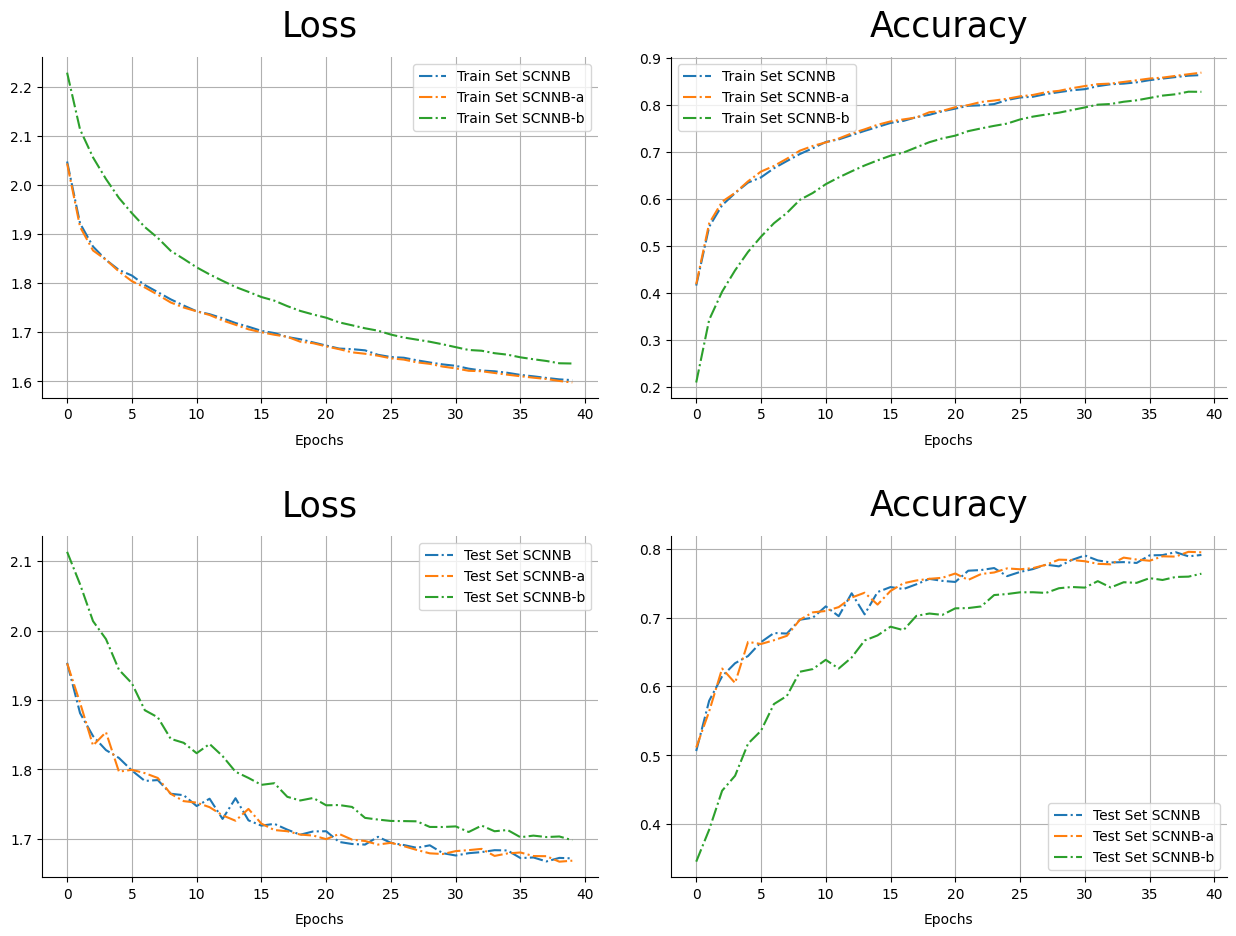

In [27]:
accloss_plots(train_loss3, test_loss3, train_acc3, test_acc3,
                  train_loss6, test_loss6, train_acc6, test_acc6,
                  train_loss9, test_loss9, train_acc9, test_acc9)